<a href="https://colab.research.google.com/github/ahmadbadawikr/DS_and_ML/blob/master/Predict_Sea_Level_Anomalies_on_the_Java_Sea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import date, datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def parse_iso8601(iso8601: str) -> date:
    return datetime.strptime(iso8601, '%Y-%m-%dT%H:%M:%S.%f').date()

df=pd.read_excel('/content/drive/My Drive/data_from_dataset zamnax.xlsx', parse_dates = True, index_col=0, date_parser=parse_iso8601)

In [ ]:
df

,Sea level anomaly [m]
time_ISO8601,
1993-01-01,-0.016
1993-01-02,-0.019
1993-01-03,-0.028
1993-01-04,-0.031
1993-01-05,-0.032
...,...
2019-10-11,-0.002
2019-10-12,0.006
2019-10-13,0.013


In [ ]:
df.isnull().sum()
df.dropna(inplace=True)

In [ ]:
df.describe()

,Sea level anomaly [m]
count,890344.000000
mean,0.037545
std,0.070010
min,-0.217000
25%,-0.010000
50%,0.037000
75%,0.084000
max,0.343000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 890344 entries, 1993-01-01 to 2019-10-15
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Sea level anomaly [m]  890344 non-null  float64
dtypes: float64(1)
memory usage: 13.6 MB


This dataset is nicely formatted and sampled and is in a much better shape. We don’t have to worry about missing values, Non discrete data and Outlier detection.

Our first step to visualize this dataset is same as any other dataset i.e. to plot a simple line plot.

Text(0, 0.5, 'Sea Level Anomaly (meter)')

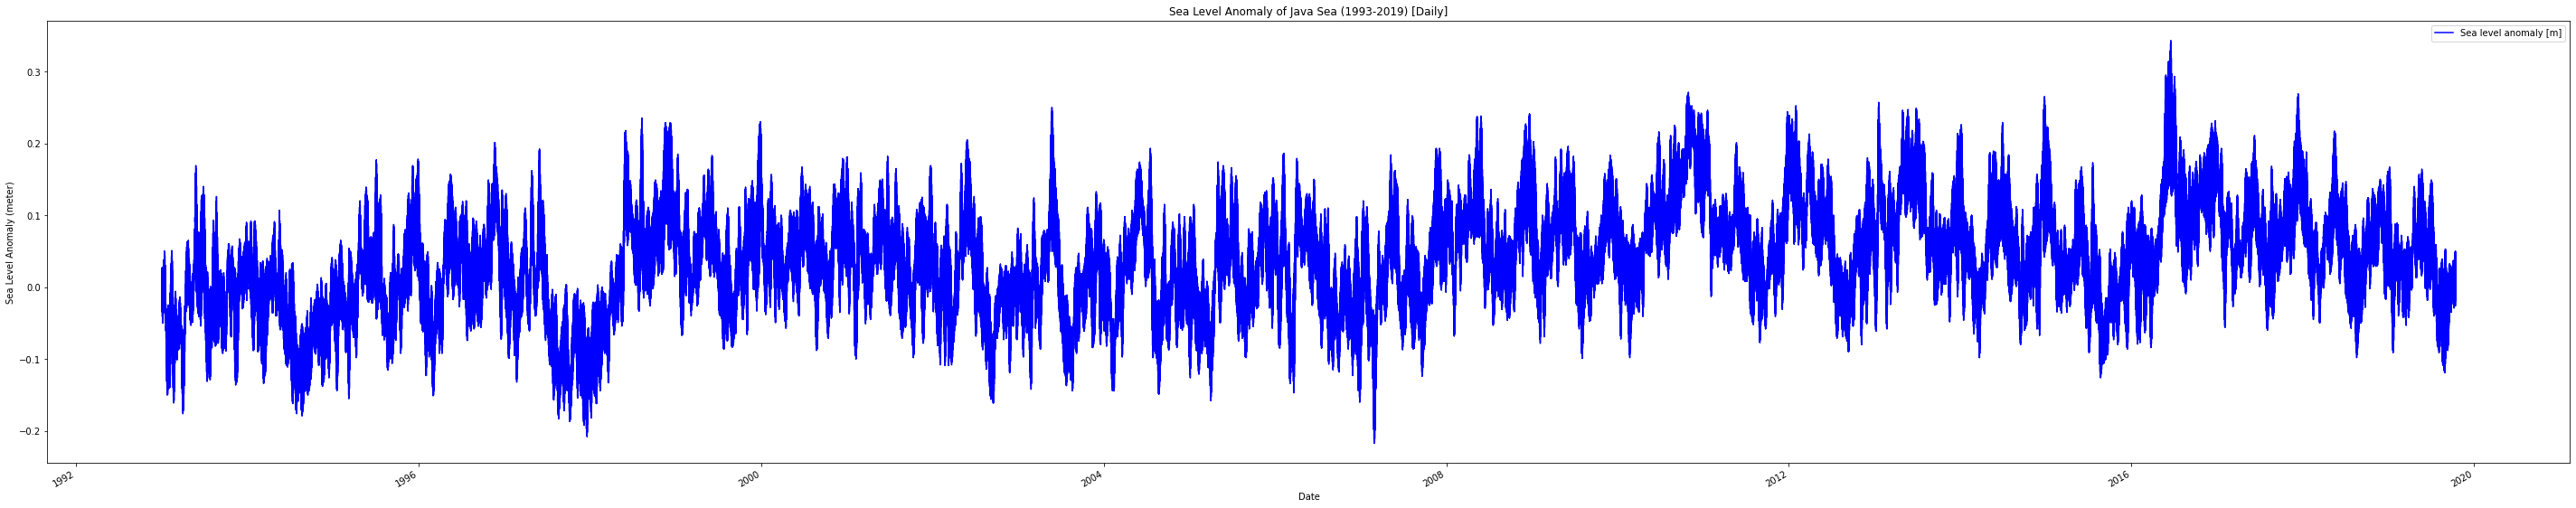

In [ ]:
dx =df.plot(figsize=(50,10), title='Sea Level Anomaly of Java Sea (1993-2019) [Daily]', color='blue')
dx.set_xlabel('Date')
dx.set_ylabel('Sea Level Anomaly (meter)')

<function matplotlib.pyplot.show>

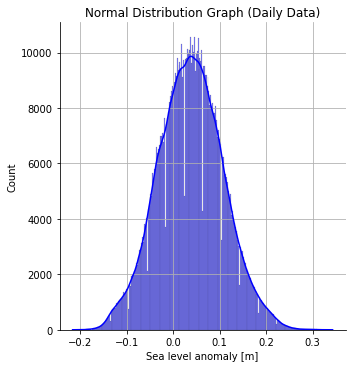

In [ ]:
import seaborn as sns

sns.displot(df['Sea level anomaly [m]'], color="blue",kde=True)
plt.title('Normal Distribution Graph (Daily Data)')
plt.grid(True)
plt.show

**Downsampling**

Decrease the frequency of the samples, from daily to annually, monthly. 


In [ ]:
resample_year = df.resample('A')
annual_mean_sla = resample_year.mean()
print(annual_mean_sla)

              Sea level anomaly [m]
time_ISO8601                       
1993-12-31                -0.018318
1994-12-31                -0.039348
1995-12-31                 0.007037
1996-12-31                 0.025875
1997-12-31                -0.036849
1998-12-31                 0.033691
1999-12-31                 0.041840
2000-12-31                 0.050518
2001-12-31                 0.040088
2002-12-31                -0.000036
2003-12-31                 0.006877
2004-12-31                 0.012111
2005-12-31                 0.016674
2006-12-31                 0.012353
2007-12-31                 0.016756
2008-12-31                 0.075261
2009-12-31                 0.063586
2010-12-31                 0.100500
2011-12-31                 0.069537
2012-12-31                 0.076087
2013-12-31                 0.096942
2014-12-31                 0.058016
2015-12-31                 0.025380
2016-12-31                 0.097693
2017-12-31                 0.087983
2018-12-31                 0

Text(0, 0.5, 'Sea Level Anomaly (meter)')

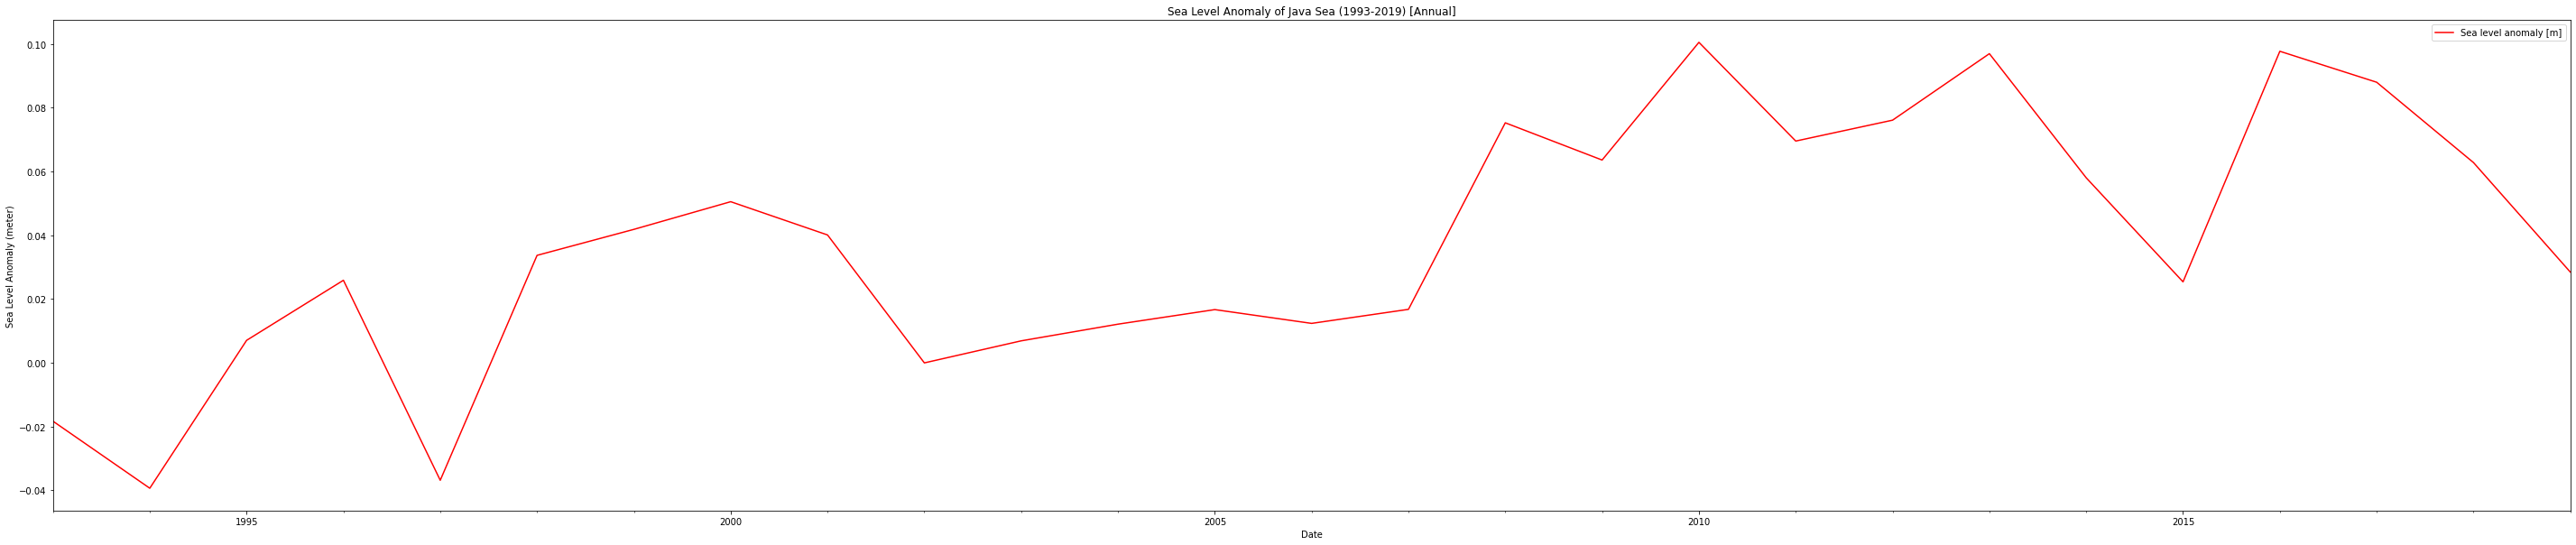

In [ ]:
ax =annual_mean_sla.plot(figsize=(50,10), title='Sea Level Anomaly of Java Sea (1993-2019) [Annual]', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sea Level Anomaly (meter)')

<function matplotlib.pyplot.show>

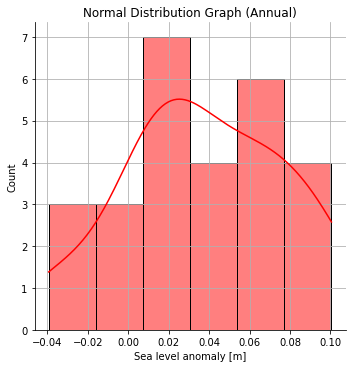

In [ ]:
sns.displot(annual_mean_sla['Sea level anomaly [m]'], color="red",kde=True)
plt.title('Normal Distribution Graph (Annual)')
plt.grid(True)
plt.show

In [ ]:
resample_month = df.resample('M')
monthly_mean_sla = resample_month.mean()
print(monthly_mean_sla)

              Sea level anomaly [m]
time_ISO8601                       
1993-01-31                -0.042965
1993-02-28                -0.069199
1993-03-31                -0.075031
1993-04-30                -0.025420
1993-05-31                 0.019955
...                             ...
2019-06-30                 0.057155
2019-07-31                 0.036672
2019-08-31                -0.035091
2019-09-30                -0.016897
2019-10-31                 0.012493

[322 rows x 1 columns]


Because we cannot check the stationarity of actual data because of hardware limitation, we decide to use monthly resampled data to check the stationarity condition by calculating the Augmented Dickey-Fuller Test statistic and using the p-value to determine stationarity.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# check stationarity in time series data of a given city

def check_stationarity(monthly_mean_sla):
    X = monthly_mean_sla["Sea level anomaly [m]"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        monthly_mean_sla = monthly_mean_sla.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True


In [ ]:
is_stationary = check_stationarity(monthly_mean_sla)

mean1=0.011574, mean2=0.063152
variance1=0.002779, variance2=0.002938
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -2.509188
p-value: 0.113255
Time Series is NOT Stationary, since p-value > 0.05


It is clear that the data is not stationary so we cannot use linear method like ARIMA, ARMA, AR, or MA. The Deep Learning method may be the better choice.

Text(0, 0.5, 'Sea Level Anomaly (meter)')

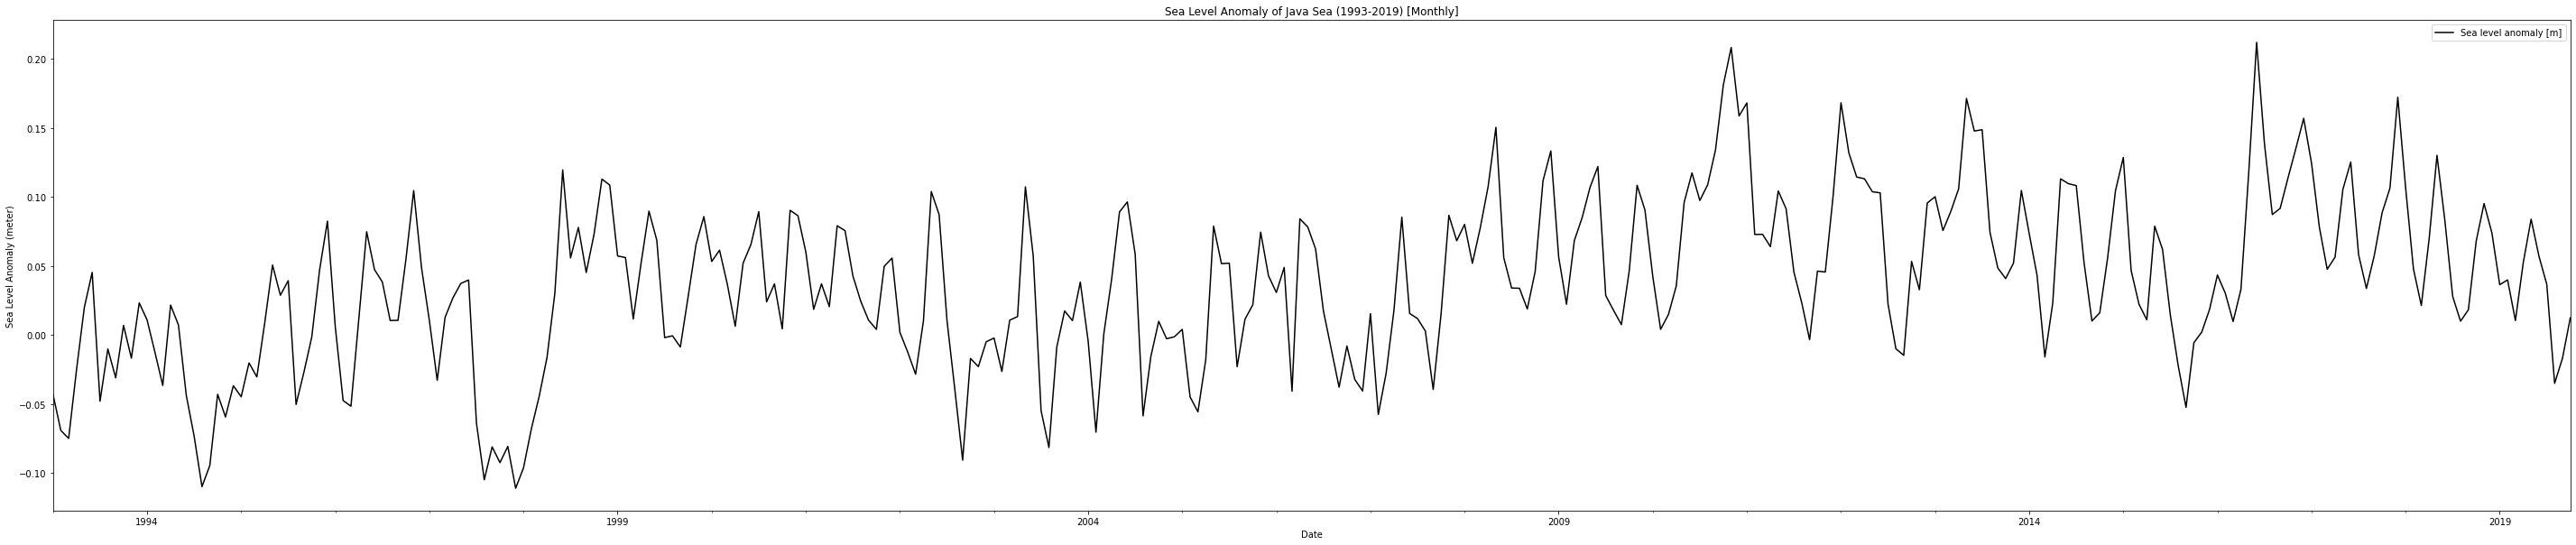

In [ ]:
mx =monthly_mean_sla.plot(figsize=(50,10), title='Sea Level Anomaly of Java Sea (1993-2019) [Monthly]', color='black')
mx.set_xlabel('Date')
mx.set_ylabel('Sea Level Anomaly (meter)')

<function matplotlib.pyplot.show>

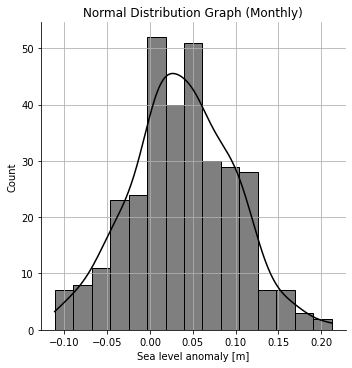

In [ ]:
sns.displot(monthly_mean_sla['Sea level anomaly [m]'], color="black",kde=True)
plt.title('Normal Distribution Graph (Monthly)')
plt.grid(True)
plt.show

A lag plot helps to check if a time series data set is random or not. A random data will be evenly spread whereas a shape or trend indicates the data is not random.

It is a scatter plot where one data point is plotted against the other with a fixed amount of lag. So a first order lag plot is using a lag of 1.

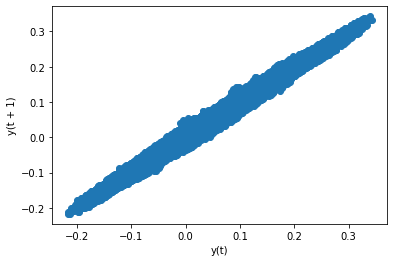

In [ ]:
pd.plotting.lag_plot(df['Sea level anomaly [m]'])

We can learn some important properties of our time series data with the help of Auto Correlation(ACF) and Partial Auto Correlation (PACF) graphs. This provide useful descriptive properties for understanding which model can be used for time series forecasting

ACF measures the linear relationships between observations at different time lags. In other words ACF is used to understand if there exists a correlation between a time series data point with another point as a function of their time difference

ACF is also called as Correlogram and a Correlogram for a Stationary process is used to Interpret Random Series, Short term correlation and Alternation Series

We will be using statsmodel Graphics API’s to plot the correlation graphs. It basically uses the matplotlib cross-correlation (xcorr) and auto correlation(acorr) under the hood. Check this matplotlib documenation



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


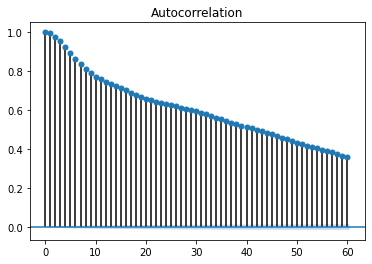

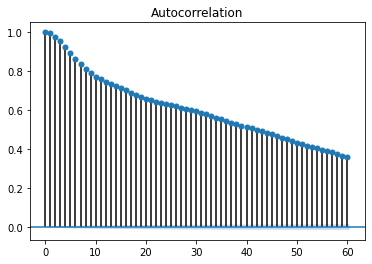

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Sea level anomaly [m]'])

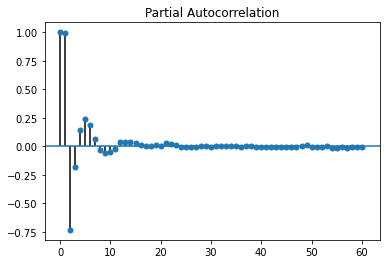

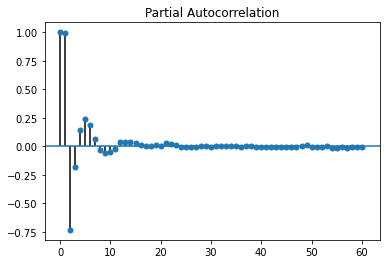

In [ ]:
sm.graphics.tsa.plot_pacf(df['Sea level anomaly [m]'])

In [ ]:
date = df.index.values
sla = df['Sea level anomaly [m]'].values

In [ ]:
date

array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ...,
       '2019-10-13T00:00:00.000000000', '2019-10-14T00:00:00.000000000',
       '2019-10-15T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
sla

array([-0.016, -0.019, -0.028, ...,  0.013,  0.022,  0.026])

In [ ]:
print("Min:", np.min(sla))
print("Max:", np.max(sla))

Min: -0.217
Max: 0.343


In [ ]:
''' Dividing data in test and train sets '''
dataset = df.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

623240 267104


In [ ]:
''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
''' Creating time frames with look backs '''
look_back = 800
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

622440
266304


In [ ]:
''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.2,
                                       min_lr=1e-6,
                                       patience=2,
                                       verbose=1)

In [ ]:
''' Fitting the data in LSTM Deep Learning model '''
from keras.layers import LSTM

model = Sequential()
start_time=time.time()
model.add(LSTM(128,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False, callbacks=[callback_early_stopping,callback_reduce_lr])

Epoch 1/300
6225/6225 [==============================] - 66s 11ms/step - loss: 0.0201 - val_loss: 0.0186
Epoch 2/300
6225/6225 [==============================] - 65s 11ms/step - loss: 0.0132 - val_loss: 0.0189
Epoch 3/300
6220/6225 [============================>.] - ETA: 0s - loss: 0.0128
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6225/6225 [==============================] - 67s 11ms/step - loss: 0.0128 - val_loss: 0.0210
Epoch 4/300
6225/6225 [==============================] - 66s 11ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 5/300
6225/6225 [==============================] - 66s 11ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 6/300
6225/6225 [==============================] - 72s 12ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 7/300
6225/6225 [==============================] - 66s 11ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 8/300
6225/6225 [==============================] - 67s 11ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 9/300

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               475648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 475,777
Trainable params: 475,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the model on Data
scores = model.evaluate(testX, testY, verbose=1)
print ("%s: %.2f%%" % (model.metrics_names, scores*100))

8322/8322 [==============================] - 22s 3ms/step - loss: 0.0053
['loss']: 0.53%


In [ ]:
#Evaluation of the Training time
print("%s Minutes of Execution" %str((time.time()-start_time)/60))

31.423280469576518 Minutes of Execution


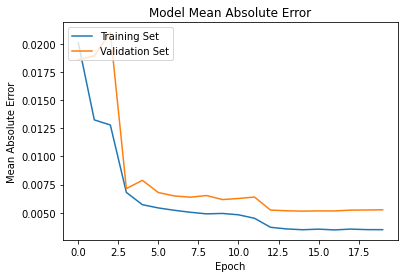

In [ ]:
#Visualize the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
''' Predicting using the model with test data as the validation '''
yhat = model.predict(testX)

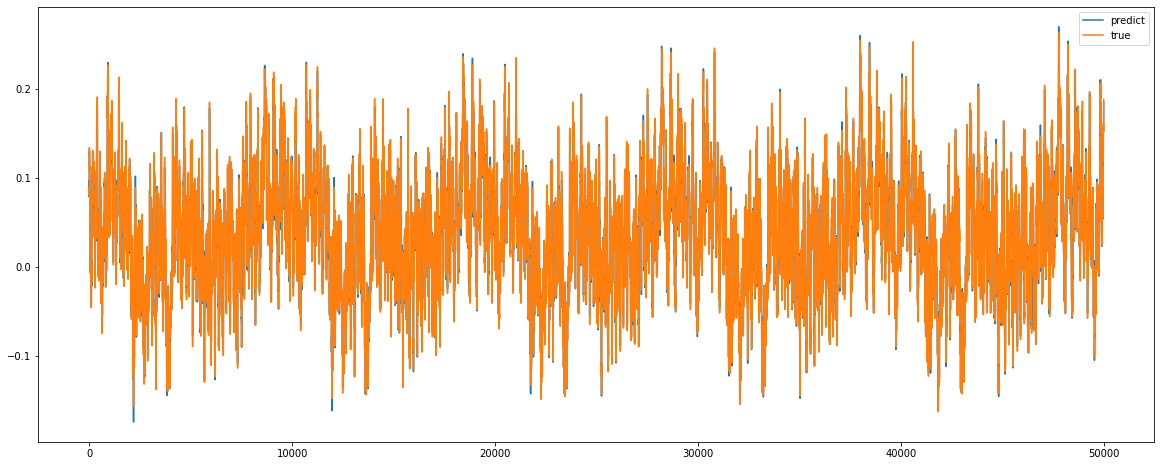

In [ ]:
''' Plotting the first 50000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat[:50000], label='predict')
plt.plot(testY[:50000], label='true')
plt.legend()
plt.show()

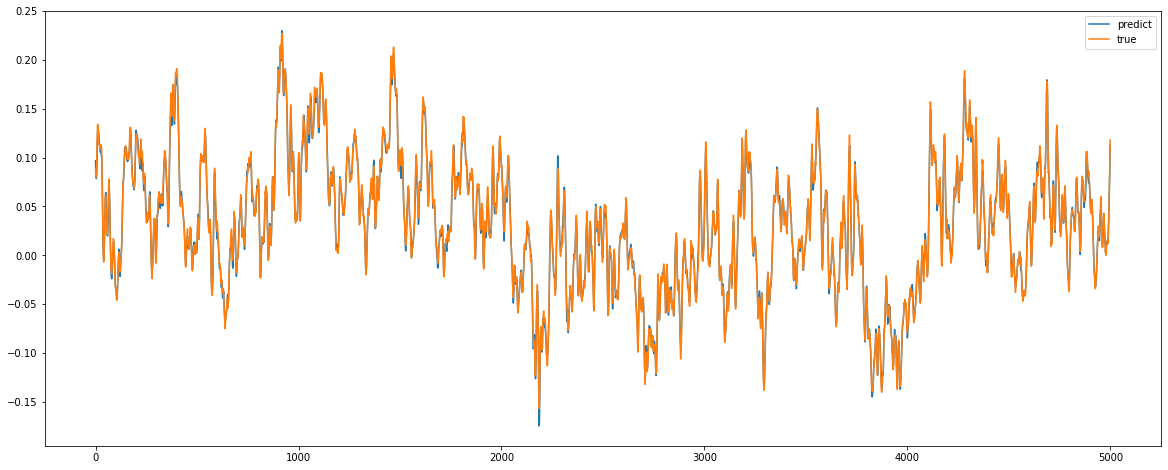

In [ ]:
''' Plotting the first 5000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat[:5000], label='predict')
plt.plot(testY[:5000], label='true')
plt.legend()
plt.show()

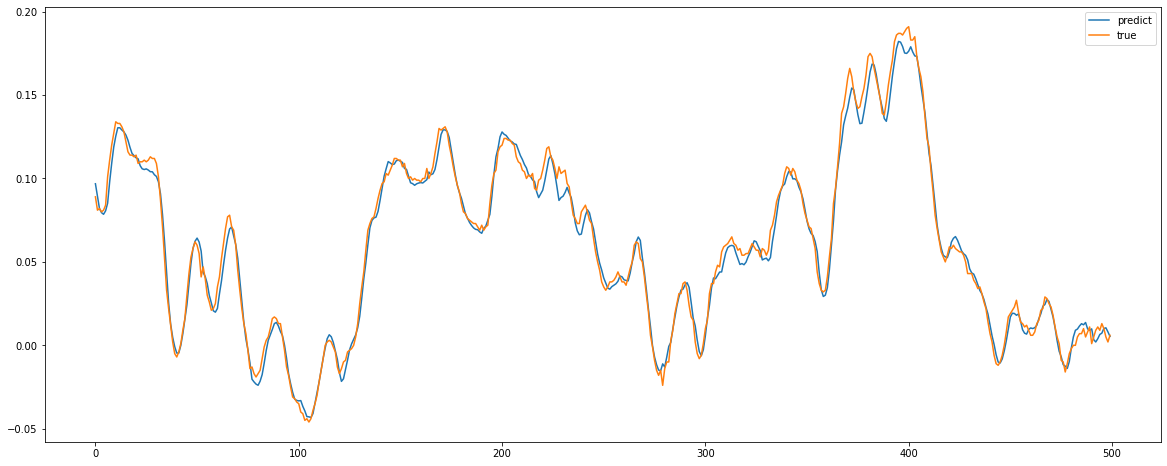

In [ ]:
''' Plotting the first 500 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat[:500], label='predict')
plt.plot(testY[:500], label='true')
plt.legend()
plt.show()

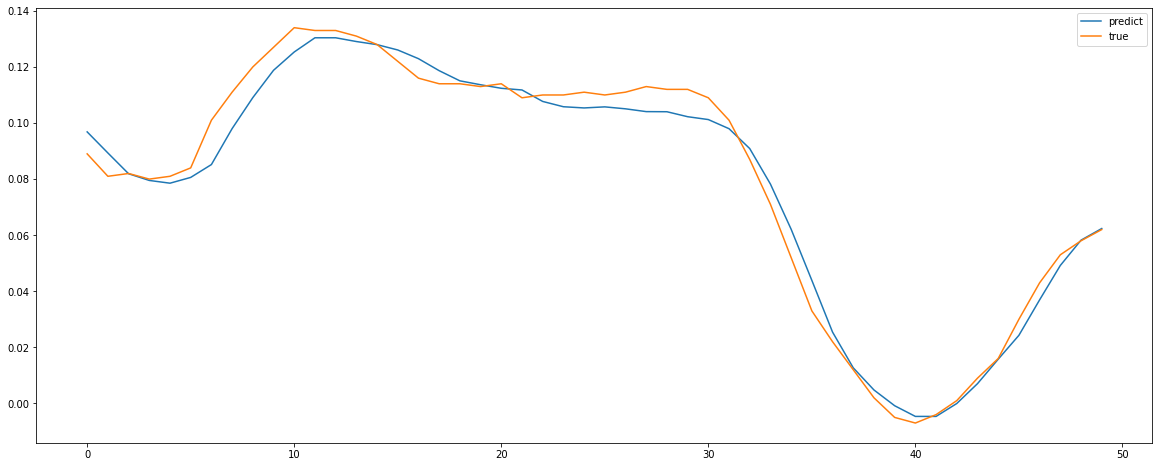

In [ ]:
''' Plotting the first 50 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat[:50], label='predict')
plt.plot(testY[:50], label='true')
plt.legend()
plt.show()

In [ ]:
print("Mean squared error: %.7f" % mean_squared_error(testY, yhat))
print("Root mean squared error: %.7f" % sqrt(mean_squared_error(testY, yhat)))
print('Variance : %.3f' % r2_score(testY, yhat))
print("Mean absolute error: %.7f" % mean_absolute_error(testY, yhat))

Mean squared error: 0.0000459
Root mean squared error: 0.0067766
Variance : 0.990
Mean absolute error: 0.0052682


In [ ]:
''' Fitting the data in RNN Deep Learning model '''

from keras.layers import SimpleRNN

start_time1=time.time()
model1 = Sequential()
model1.add(SimpleRNN(128,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
history1 = model1.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False, callbacks=[callback_early_stopping,callback_reduce_lr])

Epoch 1/300
6225/6225 [==============================] - 28s 5ms/step - loss: 0.0254 - val_loss: 0.0115
Epoch 2/300
6225/6225 [==============================] - 28s 5ms/step - loss: 0.0129 - val_loss: 0.0114
Epoch 3/300
6225/6225 [==============================] - 30s 5ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 4/300
6225/6225 [==============================] - 29s 5ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 5/300
6225/6225 [==============================] - 29s 5ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 6/300
6225/6225 [==============================] - 29s 5ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 7/300
6219/6225 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6225/6225 [==============================] - 29s 5ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 8/300
6225/6225 [==============================] - 32s 5ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 9/300
6225/62

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               118912    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 119,041
Trainable params: 119,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the model on Data
scores1 = model1.evaluate(testX, testY, verbose=1)
print ("%s: %.2f%%" % (model1.metrics_names, scores1*100))

8322/8322 [==============================] - 14s 2ms/step - loss: 0.0045
['loss']: 0.45%


In [ ]:
#Evaluation of the Training time
print("%s Minutes of Execution" %str((time.time()-start_time1)/60))

12.14268703063329 Minutes of Execution


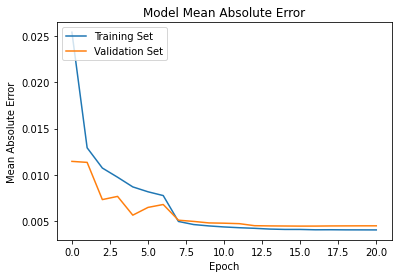

In [ ]:
#Visualize the model loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
''' Predicting using the model with test data as the validation '''
yhat1 = model1.predict(testX)

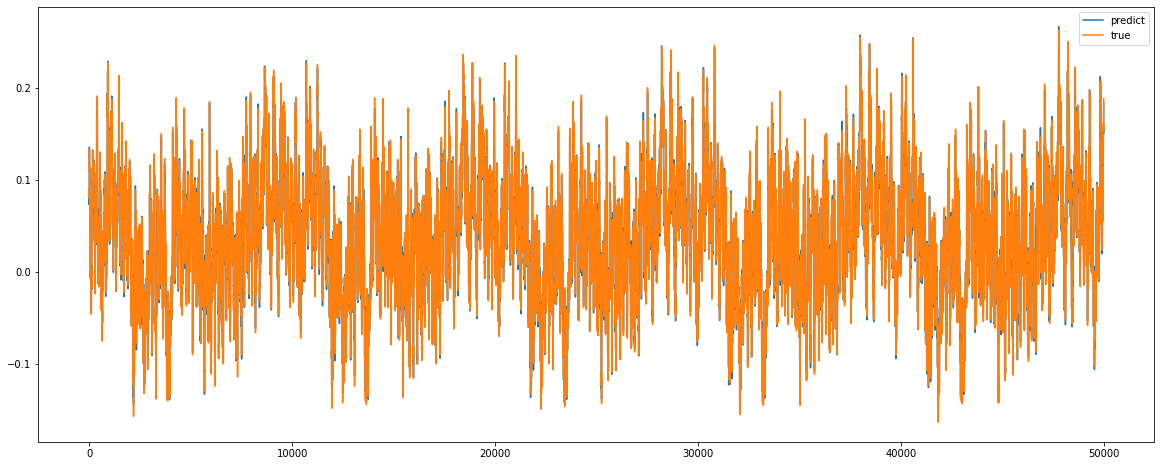

In [ ]:
''' Plotting the first 50000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat1[:50000], label='predict')
plt.plot(testY[:50000], label='true')
plt.legend()
plt.show()

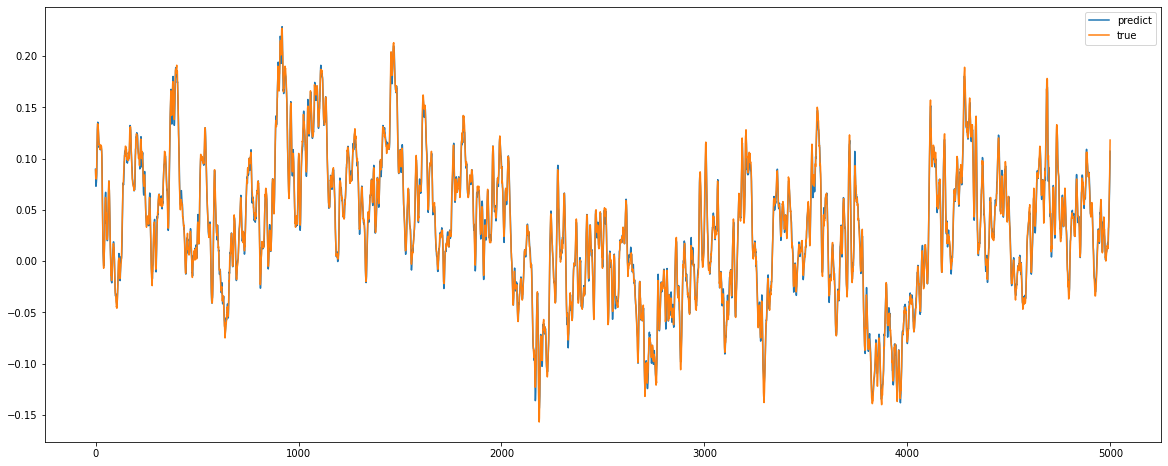

In [ ]:
''' Plotting the first 5000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat1[:5000], label='predict')
plt.plot(testY[:5000], label='true')
plt.legend()
plt.show()

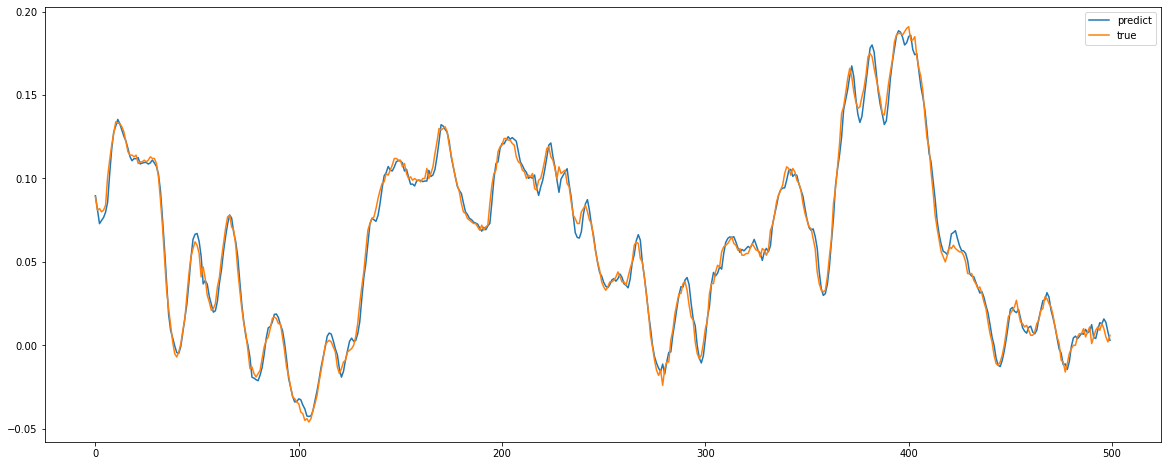

In [ ]:
''' Plotting the first 500 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat1[:500], label='predict')
plt.plot(testY[:500], label='true')
plt.legend()
plt.show()

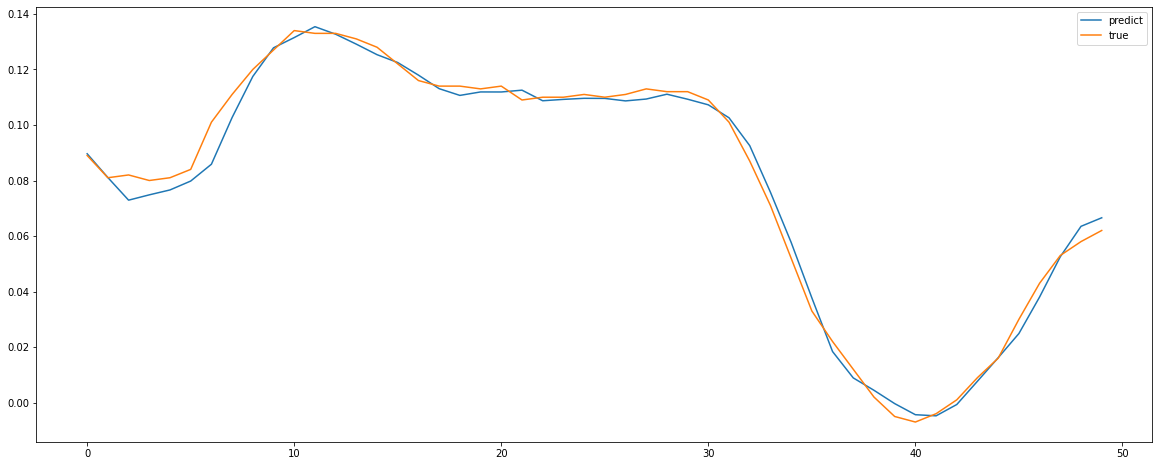

In [ ]:
''' Plotting the first 50 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat1[:50], label='predict')
plt.plot(testY[:50], label='true')
plt.legend()
plt.show()

In [ ]:
print("Mean squared error: %.7f" % mean_squared_error(testY, yhat1))
print("Root mean squared error: %.7f" % sqrt(mean_squared_error(testY, yhat1)))
print('Variance : %.3f' % r2_score(testY, yhat1))
print("Mean absolute error: %.7f" % mean_absolute_error(testY, yhat1))

Mean squared error: 0.0000343
Root mean squared error: 0.0058564
Variance : 0.993
Mean absolute error: 0.0045024


In [ ]:
''' Fitting the data in GRU Deep Learning model '''

from keras.layers import GRU

start_time2=time.time()
model2 = Sequential()
model2.add(GRU(128,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
history2 = model2.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False, callbacks=[callback_early_stopping,callback_reduce_lr])

Epoch 1/300
6225/6225 [==============================] - 51s 8ms/step - loss: 0.0212 - val_loss: 0.0216
Epoch 2/300
6225/6225 [==============================] - 50s 8ms/step - loss: 0.0123 - val_loss: 0.0163
Epoch 3/300
6225/6225 [==============================] - 51s 8ms/step - loss: 0.0104 - val_loss: 0.0207
Epoch 4/300
6225/6225 [==============================] - 51s 8ms/step - loss: 0.0094 - val_loss: 0.0121
Epoch 5/300
6225/6225 [==============================] - 51s 8ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 6/300
6225/6225 [==============================] - 50s 8ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 7/300
6225/6225 [==============================] - 53s 8ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 8/300
6225/6225 [==============================] - 51s 8ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 9/300
6225/6225 [==============================] - 52s 8ms/step - loss: 0.0077 - val_loss: 0.0096
Epoch 10/300
6225/6225 [==============================] - 53s 8m

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               357120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 357,249
Trainable params: 357,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the model on Data
scores2 = model2.evaluate(testX, testY, verbose=1)
print ("%s: %.2f%%" % (model2.metrics_names, scores2*100))

8322/8322 [==============================] - 20s 2ms/step - loss: 0.0047
['loss']: 0.47%


In [ ]:
#Evaluation of the Training time
print("%s Minutes of Execution" %str((time.time()-start_time2)/60))

25.369183127085368 Minutes of Execution


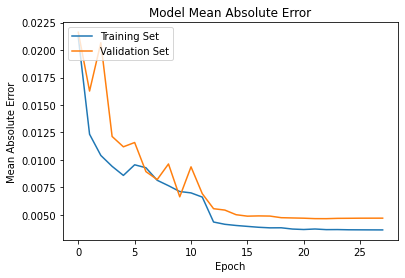

In [ ]:
#Visualize the model loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
''' Predicting using the model with test data as the validation '''
yhat2 = model2.predict(testX)

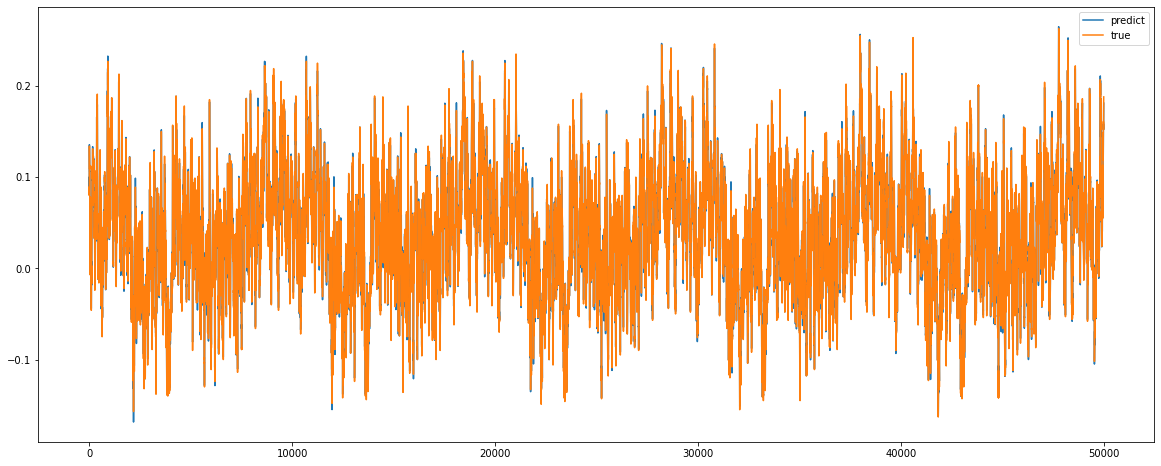

In [ ]:
''' Plotting the first 50000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat2[:50000], label='predict')
plt.plot(testY[:50000], label='true')
plt.legend()
plt.show()

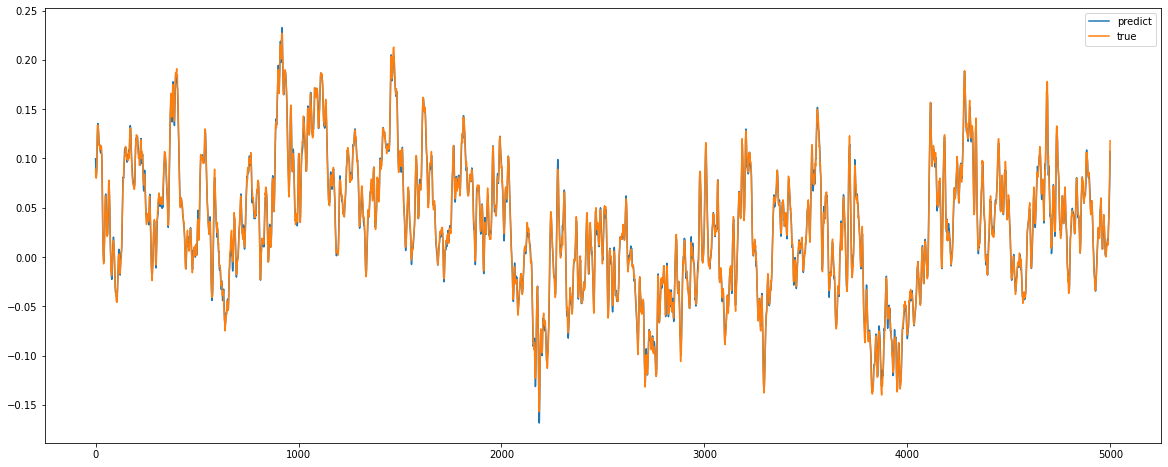

In [ ]:
''' Plotting the first 5000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat2[:5000], label='predict')
plt.plot(testY[:5000], label='true')
plt.legend()
plt.show()

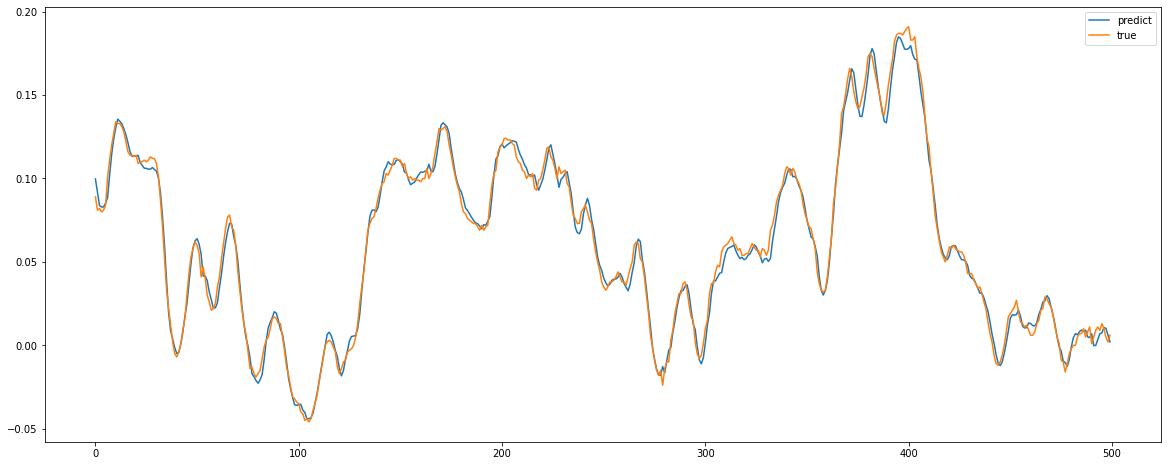

In [ ]:
''' Plotting the first 500 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat2[:500], label='predict')
plt.plot(testY[:500], label='true')
plt.legend()
plt.show()

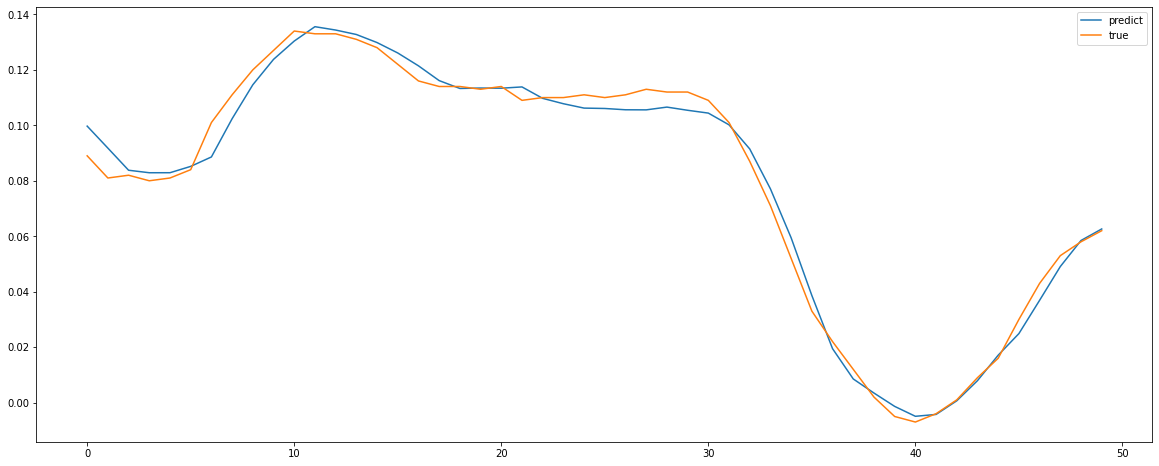

In [ ]:
''' Plotting the first 50 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat2[:50], label='predict')
plt.plot(testY[:50], label='true')
plt.legend()
plt.show()

In [ ]:
print("Mean squared error: %.7f" % mean_squared_error(testY, yhat2))
print("Root mean squared error: %.7f" % sqrt(mean_squared_error(testY, yhat2)))
print('Variance : %.3f' % r2_score(testY, yhat2))
print("Mean absolute error: %.7f" % mean_absolute_error(testY, yhat2))

Mean squared error: 0.0000365
Root mean squared error: 0.0060384
Variance : 0.992
Mean absolute error: 0.0047028


In [ ]:
# define CNN model
from keras.layers import Conv1D

start_time3=time.time()
model3 = Sequential()
model3.add(Conv1D(128,kernel_size=1,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam')
history3 = model3.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False, callbacks=[callback_early_stopping,callback_reduce_lr])

Epoch 1/300
6225/6225 [==============================] - 21s 3ms/step - loss: 0.0249 - val_loss: 0.0114
Epoch 2/300
6225/6225 [==============================] - 21s 3ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 3/300
6225/6225 [==============================] - 21s 3ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 4/300
6225/6225 [==============================] - 22s 3ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 5/300
6208/6225 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6225/6225 [==============================] - 21s 3ms/step - loss: 0.0086 - val_loss: 0.0128
Epoch 6/300
6225/6225 [==============================] - 20s 3ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/300
6225/6225 [==============================] - 21s 3ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 8/300
6211/6225 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00008: ReduceLROnPlateau reducing lea

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 128)            102528    
_________________________________________________________________
dense (Dense)                (None, 1, 1)              129       
Total params: 102,657
Trainable params: 102,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the model on Data
scores3 = model3.evaluate(testX, testY, verbose=1)
print ("%s: %.2f%%" % (model3.metrics_names, scores3*100))

8322/8322 [==============================] - 12s 1ms/step - loss: 0.0048
['loss']: 0.48%


In [ ]:
#Evaluation of the Training time
print("%s Minutes of Execution" %str((time.time()-start_time3)/60))

7.392525315284729 Minutes of Execution


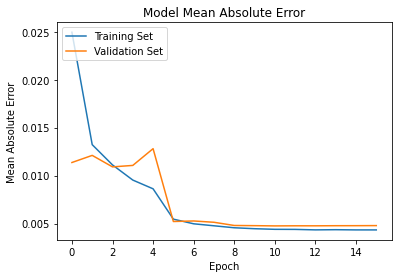

In [ ]:
#Visualize the model loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
''' Predicting using the model with test data as the validation '''
yhat3 = model3.predict(testX)

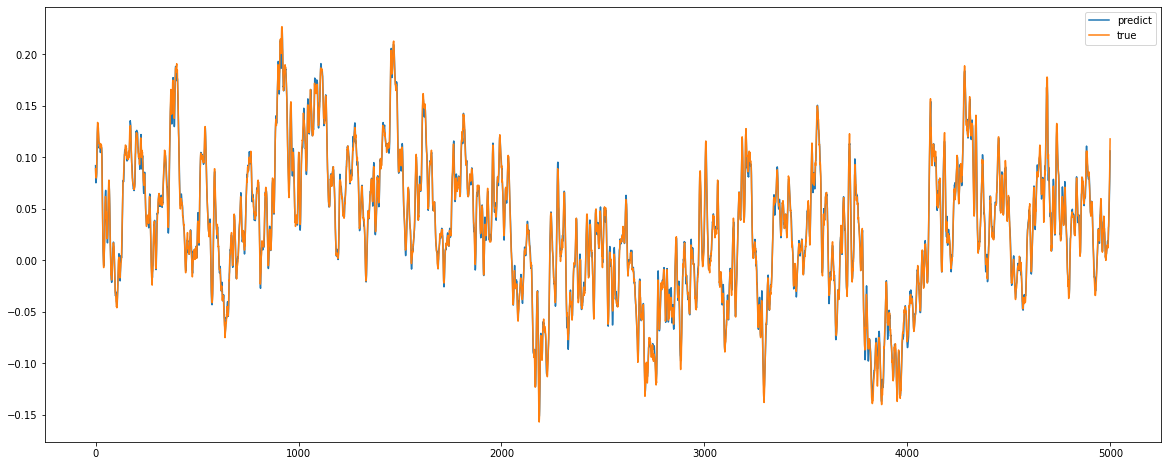

In [ ]:
''' Plotting the first 5000 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat3.reshape(-1,)[:5000], label='predict')
plt.plot(testY[:5000], label='true')
plt.legend()
plt.show()

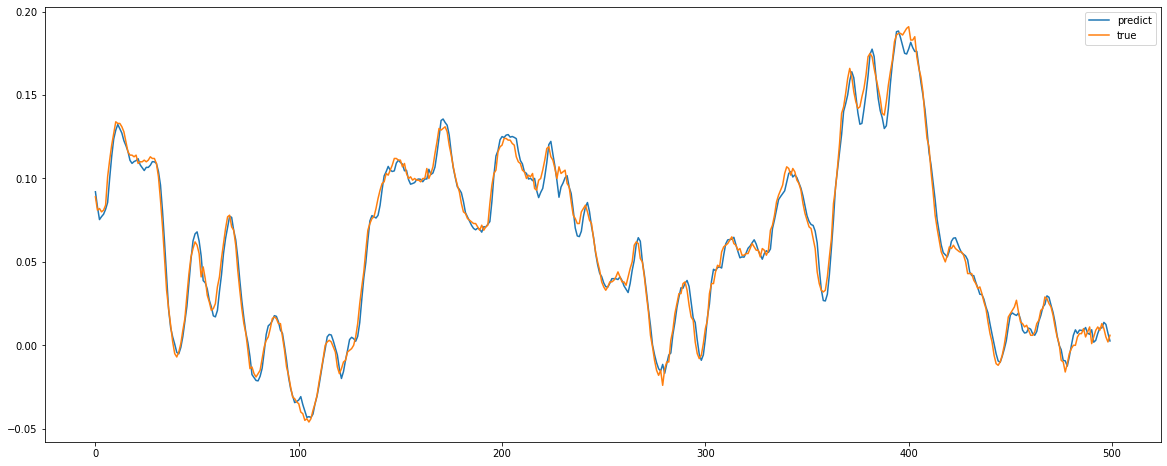

In [ ]:
''' Plotting the first 500 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat3.reshape(-1,)[:500], label='predict')
plt.plot(testY[:500], label='true')
plt.legend()
plt.show()

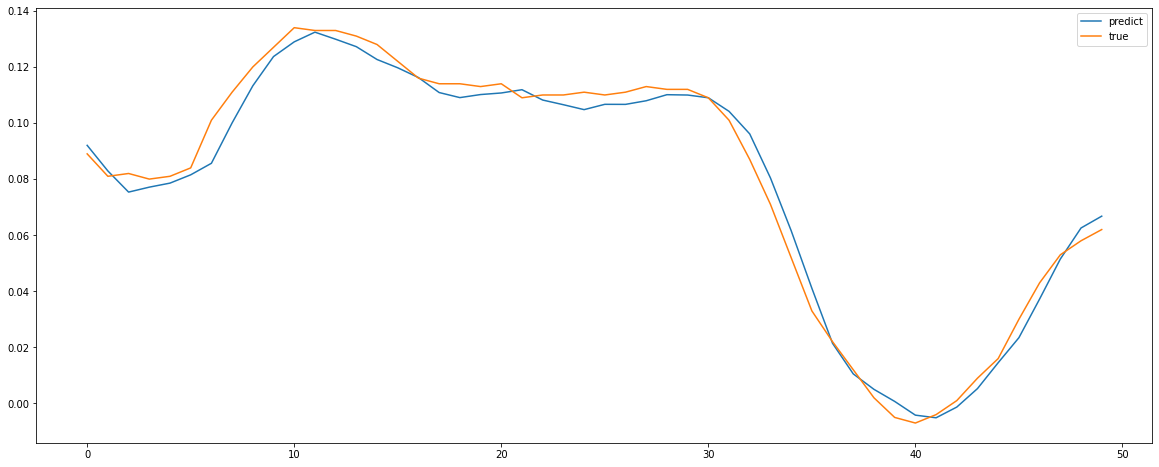

In [ ]:
''' Plotting the first 50 entries to see prediction '''
plt.figure(figsize=(20,8))
plt.plot(yhat3.reshape(-1,)[:50], label='predict')
plt.plot(testY[:50], label='true')
plt.legend()
plt.show()

In [ ]:
print("Mean squared error: %.7f" % mean_squared_error(testY, yhat3.reshape(-1,)))
print("Root mean squared error: %.7f" % sqrt(mean_squared_error(testY, yhat3.reshape(-1,))))
print('Variance : %.3f' % r2_score(testY, yhat3.reshape(-1,)))
print("Mean absolute error: %.7f" % mean_absolute_error(testY, yhat3.reshape(-1,)))

Mean squared error: 0.0000381
Root mean squared error: 0.0061708
Variance : 0.992
Mean absolute error: 0.0047891
